# Import Libralies

In [36]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

## Read the data file

In [17]:
def read_datafile(filepath):
    """reads the data file and pastes into a data frame."""
    df = pd.read_csv(filepath)
    return df

filepath = 'Wholesale customers data.csv'
df = read_datafile(filepath)

df.sample(7)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
184,1,3,327,918,4710,74,334,11
183,1,3,36847,43950,20170,36534,239,47943
205,2,1,1107,11711,23596,955,9265,710
263,1,1,2153,1115,6684,4324,2894,411
22,1,3,31276,1917,4469,9408,2381,4334
45,2,3,5181,22044,21531,1740,7353,4985
175,2,3,2343,7845,11874,52,4196,1697


## Get overview of the data

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [19]:
df.shape

(440, 8)

In [20]:
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [21]:
df.duplicated().sum()

0

## Data Exploratory Analysis

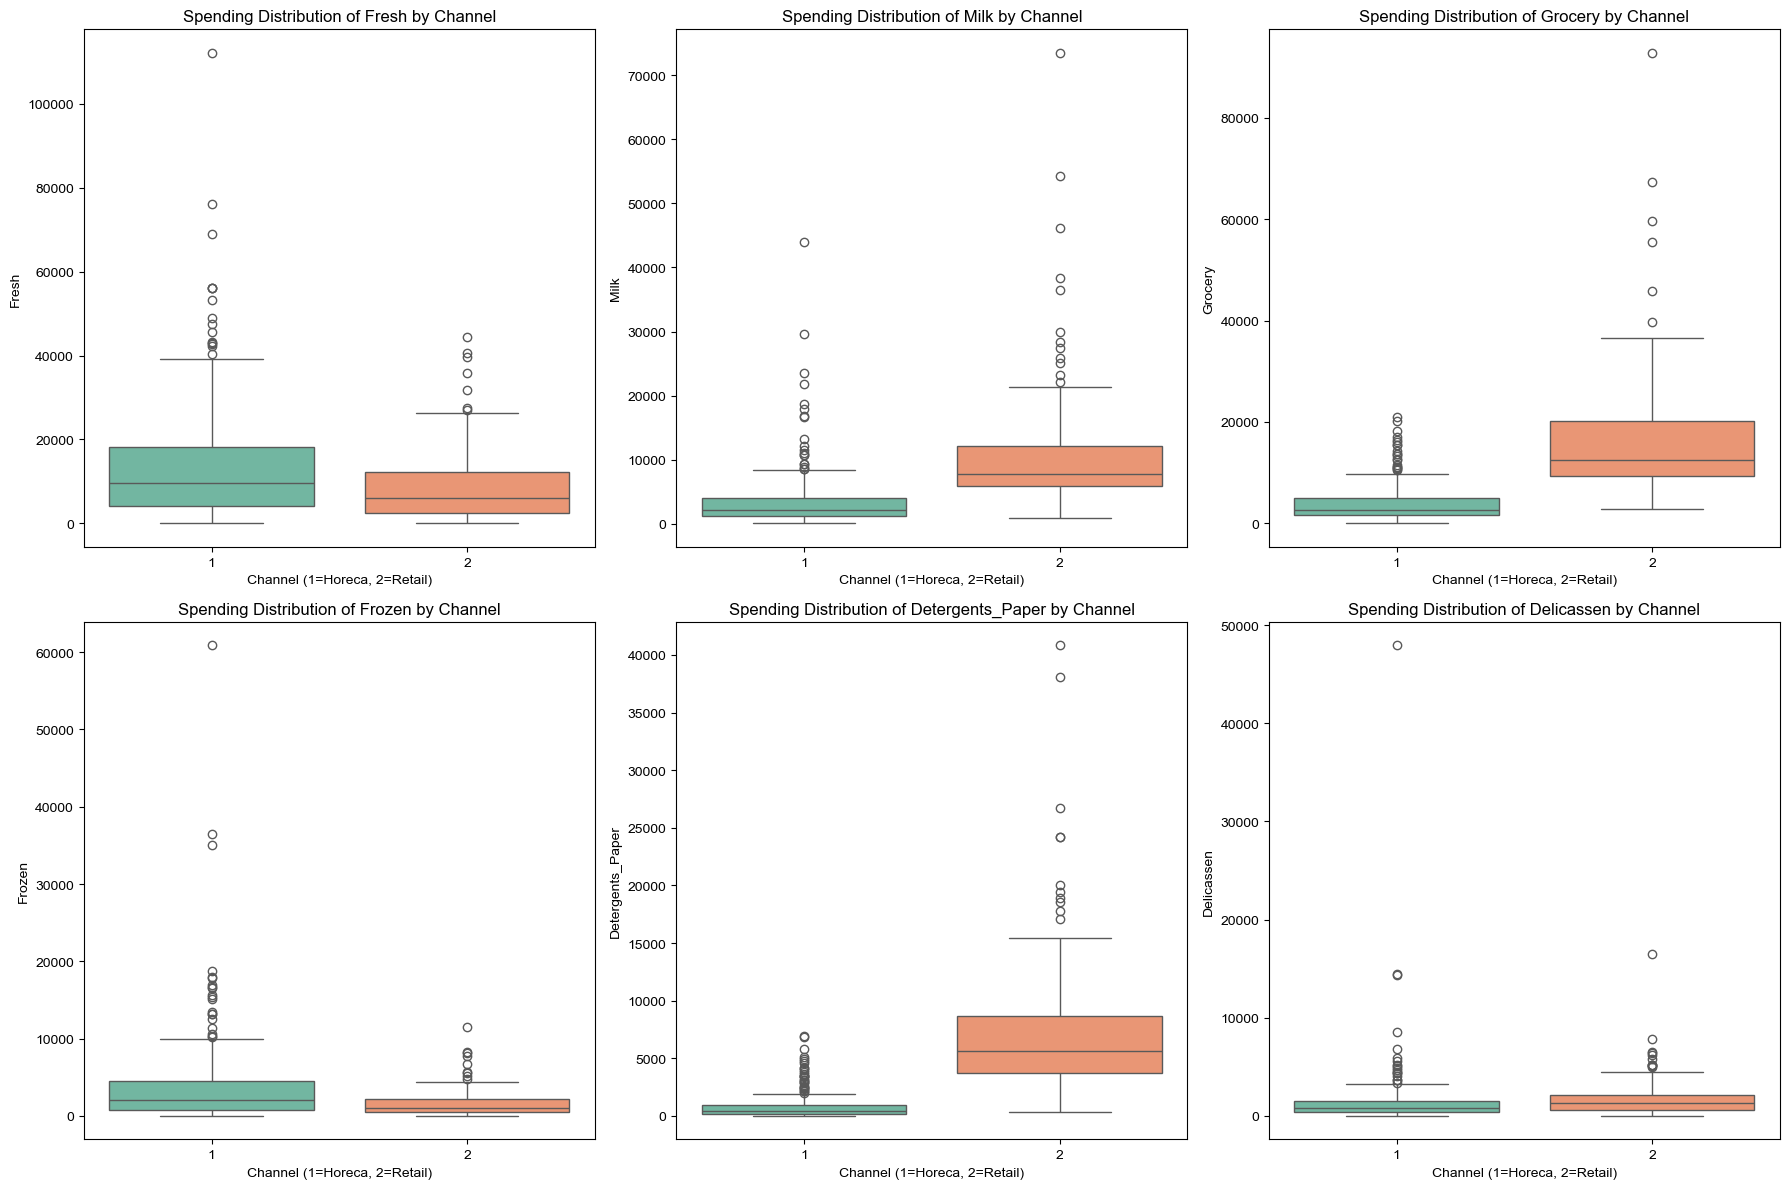

In [22]:
# Create a list of the 6 spending features
spending_features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

# Create a figure with a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
plt.style.use('seaborn-v0_8-whitegrid')

# Flatten the axes array for easy iteration (0,0, 0,1, 0,2, 1,0, 1,1, 1,2)
axes = axes.flatten()

# Loop through each spending feature and plot its distribution by Channel
for i, feature in enumerate(spending_features):
    # The corrected line (assigning hue=x and setting legend=False):
    sns.boxplot(x='Channel', y=feature, data=df, ax=axes[i], palette='Set2', hue='Channel', legend=False)
    axes[i].set_title(f'Spending Distribution of {feature} by Channel')
    axes[i].set_xlabel('Channel (1=Horeca, 2=Retail)')

plt.tight_layout()
plt.show()

## Data Preparation

## Log Transformation

In [23]:
# A. Log Transformation to all 6 spending columns
spending_features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
df_log = df.copy()

# Apply log(x+1) transformation
df_log[spending_features] = np.log1p(df_log[spending_features])

## Standard Scaling

In [24]:
# 1. Categorical Encoding (One-Hot Encoding)
# We convert 'Channel' and 'Region' into binary columns (dummies)
df_encoded = pd.get_dummies(df_log, columns=['Channel', 'Region'], drop_first=False)

# Note: If you used drop_first=False above (as shown in the code), you keep all columns
# For clustering, keeping all dummy columns is often fine, but let's select ALL for safety:
X_features = df_encoded.columns

# 3. Apply Standard Scaling
scaler = StandardScaler()

# Fit and transform the data
X_scaled_array = scaler.fit_transform(df_encoded.values)

# Convert the array back to a DataFrame for easier handling in the next steps (PCA)
X_scaled = pd.DataFrame(X_scaled_array, columns=df_encoded.columns)

In [25]:
# C. PCA (Max Components for subsequent selection)
pca_max = PCA(n_components=X_scaled.shape[1], random_state=42)

X_pca = pca_max.fit_transform(X_scaled)

## Dimension Reduction using PCA

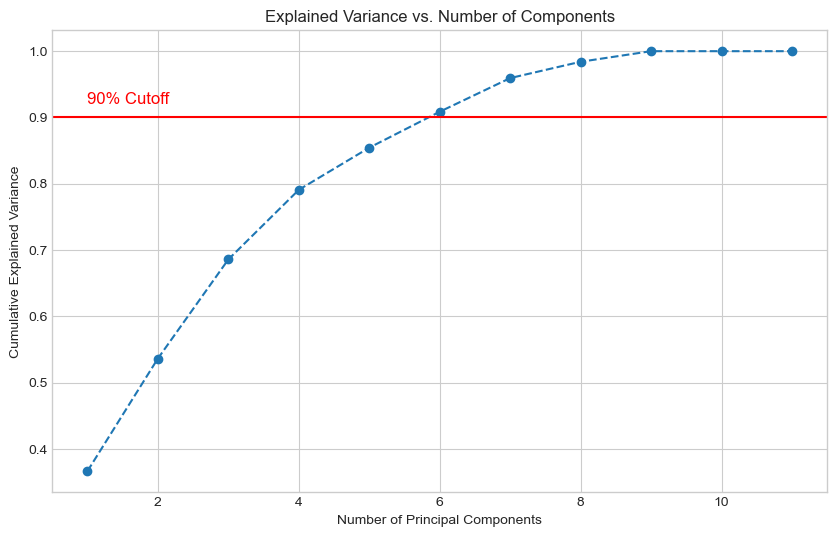


Total Features: 11
Number of components needed to explain 90% variance: 6

Shape of the final PCA data (X_pca) using N=3: (440, 3)


In [26]:
# --- Dimension Reduction using PCA (Exploration & Justification) ---

# 1. Analyze Explained Variance (for the plot and the 90% justification)
# Use n_components=None to calculate the variance for all components
pca_analysis = PCA(n_components=None, random_state=42)
pca_analysis.fit(X_scaled)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca_analysis.explained_variance_ratio_)

# Plot the explained variance to justify dimensionality reduction
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Explained Variance vs. Number of Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.90, color='r', linestyle='-')
plt.text(1, 0.92, '90% Cutoff', color = 'red', fontsize=12)
plt.grid(True)
plt.show()

# Find the optimal number of components for 90% variance (for documentation)
n_components_90 = np.where(cumulative_variance >= 0.90)[0][0] + 1
print(f"\nTotal Features: {X_scaled.shape[1]}")
print(f"Number of components needed to explain 90% variance: {n_components_90}")
# (This typically outputs 6)

# 2. Final PCA Application (Using the Optimal N=3 found through Silhouette Score)
N_COMPONENTS_OPTIMAL = 3 
pca_final = PCA(n_components=N_COMPONENTS_OPTIMAL, random_state=42)
X_pca = pca_final.fit_transform(X_scaled) # X_pca now holds the 3-component data

print(f"\nShape of the final PCA data (X_pca) using N={N_COMPONENTS_OPTIMAL}: {X_pca.shape}")

## Determine the optimal number of clusters

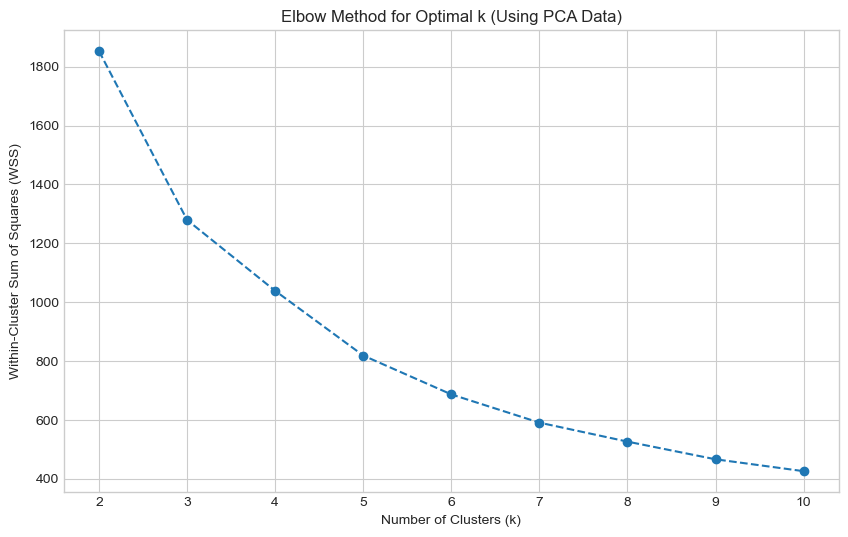

In [27]:
# Define the range of k values to test
k_range = range(2, 11) 
wss = [] # List to hold the WSS values

# Loop through the range of k values
for k in k_range:
    # Initialize KMeans with the current k
    # We use n_init=200 for a robust result
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=200, random_state=42)
    
    # Fit the model to the PCA data
    kmeans.fit(X_pca)
    
    # Append the WSS (inertia_) to the list
    wss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k (Using PCA Data)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

## Calculate the Silhouette Score

In [28]:
# Define the range of k values to test
k_range = range(2, 11) 
silhouette_scores = {} # Dictionary to hold k: score pairs

# Loop through the range of k values
for k in k_range:
    # Initialize and fit KMeans (using the robust parameters)
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=200, random_state=42)
    kmeans.fit(X_pca)
    
    # Calculate the Silhouette Score
    score = silhouette_score(X_pca, kmeans.labels_)
    silhouette_scores[k] = score

# Convert results to a DataFrame for clean presentation
scores_df = pd.DataFrame(list(silhouette_scores.items()), columns=['k', 'Silhouette_Score']).set_index('k')

print("Silhouette Scores for k=2 to k=10:")
print(scores_df)

Silhouette Scores for k=2 to k=10:
    Silhouette_Score
k                   
2           0.441919
3           0.468344
4           0.484542
5           0.422203
6           0.422516
7           0.442956
8           0.422172
9           0.387587
10          0.386080


## Fit the data

In [29]:
N_COMPONENTS_FINAL = 3 
OPTIMAL_K = 4

# Select the optimal PCA components
X_pca_final = X_pca[:, :N_COMPONENTS_FINAL]

# Fit the Final K-Means Model
kmeans = KMeans(n_clusters=OPTIMAL_K, init='k-means++', n_init=200, random_state=42)
kmeans.fit(X_pca_final)
y_pred = kmeans.labels_

# Add the cluster labels to the original DataFrame (df) for interpretation
df['Cluster'] = y_pred

## Final Perfornamce Metric

In [30]:
# Silhouette Score
final_silhouette = silhouette_score(X_pca_final, y_pred)

# Adjusted Rand Index (ARI) against Channel (Proxy for Ground Truth)
true_labels_proxy = df['Channel']
final_ari_score = adjusted_rand_score(true_labels_proxy, y_pred)

print(f"--- FINAL MODEL PERFORMANCE (N_Components={N_COMPONENTS_FINAL}, k={OPTIMAL_K}) ---")
print(f"Silhouette Score: {final_silhouette:.4f}")
print(f"Adjusted Rand Index (ARI) Score: {final_ari_score:.4f}")

--- FINAL MODEL PERFORMANCE (N_Components=3, k=4) ---
Silhouette Score: 0.4845
Adjusted Rand Index (ARI) Score: 0.5347


## Cluster Interpretation (Profiling)

In [31]:
cluster_analysis = df.groupby('Cluster').mean(numeric_only=True)
print("Cluster Analysis (Mean values in ORIGINAL CURRENCY/COUNTS):")
cluster_analysis

Cluster Analysis (Mean values in ORIGINAL CURRENCY/COUNTS):


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster,,,,,,,,
0,1.972222,3.000000,10644.527778,11078.074074,15898.546296,1630.546296,6880.490741,1868.990741
1,1.000000,3.000000,13514.269231,3328.495192,3741.384615,3626.889423,708.254808,1491.629808
2,1.972973,1.486486,5894.297297,10231.729730,17715.945946,1772.972973,8468.810811,1517.243243
3,1.011494,1.333333,12660.517241,3253.149425,3997.942529,4086.873563,736.793103,1180.402299


## Visualization of Clusters

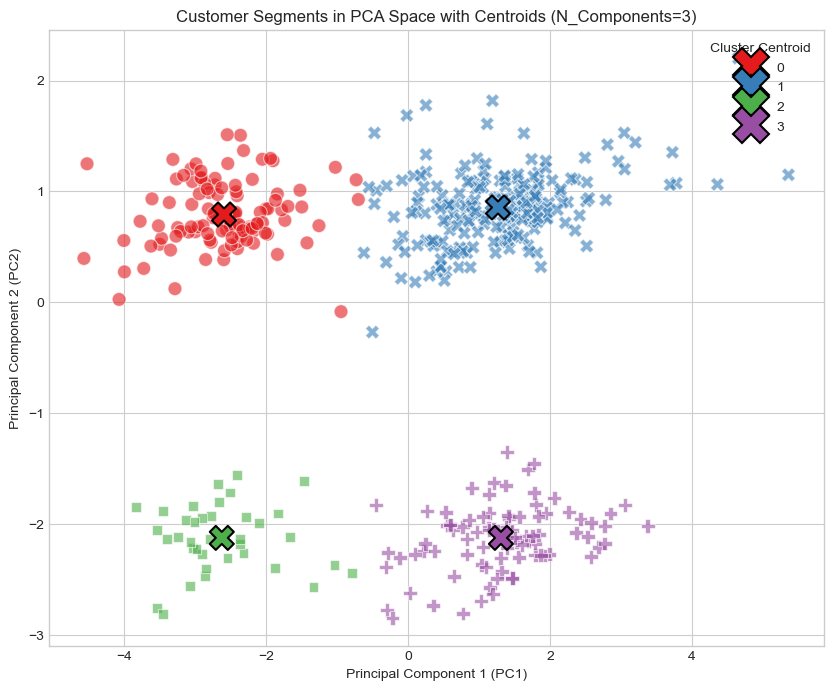

In [ ]:
# 1. Prepare data for the scatter plot
pca_df = pd.DataFrame(X_pca_final[:, 0:2], columns=['PC1', 'PC2'])
pca_df['Cluster'] = y_pred

# 2. Extract and prepare Centroids
centroids = kmeans.cluster_centers_[:, 0:2]
centroids_df = pd.DataFrame(centroids, columns=['PC1', 'PC2'])
centroids_df['Cluster'] = range(OPTIMAL_K) # Assign cluster labels 0, 1, 2, 3

# 3. Create the plot
plt.figure(figsize=(10, 8))

# Scatter plot of all data points
sns.scatterplot(
    data=pca_df, 
    x='PC1', 
    y='PC2', 
    hue='Cluster', 
    palette='Set1', 
    style='Cluster',
    s=100,
    alpha=0.6, # Make points slightly transparent
    legend=False # Do not show legend for the small points
)

# Scatter plot for the centroids (overlayed)
sns.scatterplot(
    data=centroids_df,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='Set1',
    marker='X',     # Use an 'X' marker for high visibility
    s=300,          # Larger size
    edgecolor='black',
    linewidth=1.5,
    legend='full'
)

plt.title(f'Customer Segments in PCA Space with Centroids (N_Components={N_COMPONENTS_FINAL})')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
# Rename legend title to reflect the centroids
plt.legend(title='Cluster Centroid', loc='upper right', markerscale=1.5)
plt.grid(True)
plt.show()

## Intersection Matrix (Contingency Matrix)


Final Intersection Matrix (True Channel vs. Predicted Clusters):
                  Cluster 0  Cluster 1  Cluster 2  Cluster 3
True: Horeca (1)          3        208          1         86
True: Retail (2)        105          0         36          1


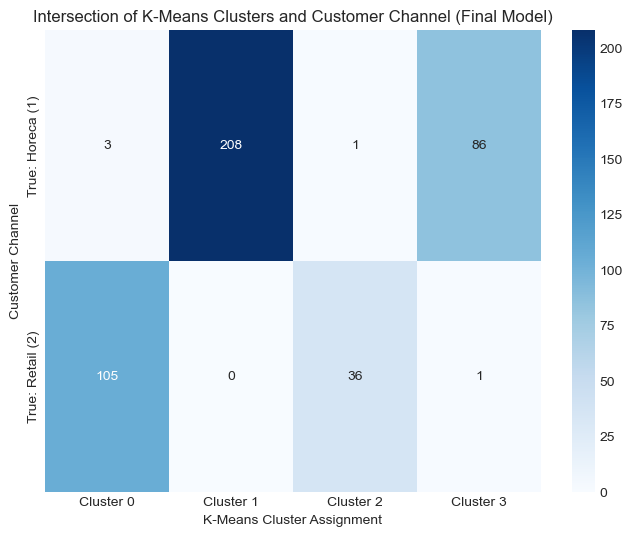

In [35]:
# 1. Use pandas crosstab to get the Intersection Matrix
cm_df = pd.crosstab(index=df['Channel'], columns=df['Cluster'], 
                    rownames=['True Channel'], colnames=['Cluster Prediction'])

# 2. Rename for clarity
cm_df.index = ['True: Horeca (1)', 'True: Retail (2)']
cm_df.columns = [f'Cluster {c}' for c in cm_df.columns]

# 3. Print the result
print("\nFinal Intersection Matrix (True Channel vs. Predicted Clusters):")
print(cm_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Intersection of K-Means Clusters and Customer Channel (Final Model)')
plt.xlabel('K-Means Cluster Assignment')
plt.ylabel('Customer Channel')
plt.show()